In [1]:
'''
Notebook to compare results from different MC maps produced in the MCeff notebook

Run in Python 3; install pymangle, fitsio, healpy locally: pip install --user fitsio; pip install --user healpy; git clone https://github.com/esheldon/pymangle...

'''

import fitsio
import numpy as np
#from desitarget.io import read_targets_in_hp, read_targets_in_box, read_targets_in_cap
import astropy.io.fits as fits
import glob
import os
import healpy as hp
from matplotlib import pyplot as plt


In [2]:
#Some information is in pixelized map
#get nside and nest from header
pixfn      = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
hdr        = fits.getheader(pixfn,1)
nside,nest = hdr['HPXNSIDE'],hdr['HPXNEST']
hpq = fitsio.read(pixfn)
print(hpq.dtype.names)

('HPXPIXEL', 'FRACAREA', 'STARDENS', 'EBV', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSFDEPTH_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'ELG', 'LRG', 'QSO', 'BGS_ANY', 'MWS_ANY', 'ALL', 'STD_FAINT', 'STD_BRIGHT', 'LRG_1PASS', 'LRG_2PASS', 'BGS_FAINT', 'BGS_BRIGHT', 'BGS_WISE', 'MWS_BROAD', 'MWS_MAIN_RED', 'MWS_MAIN_BLUE', 'MWS_WD', 'MWS_NEARBY')


In [3]:
#get different MC efficiency maps
mcf = fitsio.read(os.getenv('SCRATCH')+'/ELGMCeffHSCHPsedext.fits')
mmc = np.mean(mcf['EFF'])
mclse = np.zeros(12*nside*nside)
for i in range(0,len(mcf)):
    pix = mcf['HPXPIXEL'][i]
    mclse[pix] = mcf['EFF'][i]/mmc
mcf = fitsio.read(os.getenv('SCRATCH')+'/ELGMCeffHSCHP.fits')
mmc = np.mean(mcf['EFF'])
mclo = np.zeros(12*nside*nside)
for i in range(0,len(mcf)):
    pix = mcf['HPXPIXEL'][i]
    mclo[pix] = mcf['EFF'][i]/mmc    
mcf = fitsio.read(os.getenv('SCRATCH')+'/ELGMCeffHSCHPsed.fits')
mmc = np.mean(mcf['EFF'])
mcls = np.zeros(12*nside*nside)
for i in range(0,len(mcf)):
    pix = mcf['HPXPIXEL'][i]
    mcls[pix] = mcf['EFF'][i]/mmc        

In [41]:
def plotvshp_compmc(r1,d1,sys,rng,gdzm=20,ebvm=0.15,useMCeff=True,correctstar=True,title='',effac=1.,south=True):
    w = hpq['GALDEPTH_Z'] > gdzm
    w &= hpq['EBV'] < ebvm
    if useMCeff:
        w &= mclse > 0
    if sys != 'gdc' and sys != 'rdc' and sys != 'zdc':
        sm = hpq[w][sys]
        xlab = sys
    else:
        if sys == 'gdc':
            print('g band depth, extinction corrected')
            sm = hpq[w]['GALDEPTH_G']*10.**(-0.4*3.214*hpq[w]['EBV'])
            xlab = 'g band depth, extinction corrected'
        if sys == 'rdc':
            sm = hpq[w]['GALDEPTH_R']*10.**(-0.4*2.165*hpq[w]['EBV'])
            xlab = 'r band depth, extinction corrected'
        if sys == 'zdc':
            sm = hpq[w]['GALDEPTH_Z']*10.**(-0.4*1.211*hpq[w]['EBV'])
            xlab = 'z band depth, extinction corrected'
    ds = np.ones(len(d1))
    hdnoc = np.histogram(sm,weights=d1[w],range=rng)
    #print(hd1)
    hr1 = np.histogram(sm,weights=r1[w],bins=hdnoc[1],range=rng)
    xl = []
    for i in range(0,len(hr1[0])):
        xl.append((hr1[1][i]+hr1[1][i+1])/2.)

    plt.errorbar(xl,hdnoc[0]/hr1[0]/(sum(d1[w])/sum(r1[w])),np.sqrt(hdnoc[0])/hr1[0]/(lelg/len(relg)),fmt='ko',label='raw')
    ds = ws
    hd1 = np.histogram(sm,weights=d1[w]*ds[w],bins=hdnoc[1],range=rng)
    plt.plot(xl,hd1[0]/hr1[0]/(sum(d1[w]*ds[w])/sum(r1[w])),'k--',label='with stellar density weights')
    dmcse = mclse**effac
    hd1 = np.histogram(sm,weights=d1[w]*ds[w]/dmcse[w],bins=hdnoc[1],range=rng)
    plt.plot(xl,hd1[0]/hr1[0]/(sum(d1[w]*ds[w]/dmcse[w])/sum(r1[w])),'r-',label='+MC; sed w ext flux (correct?)')
    dmcs = mcls**effac
    hd1 = np.histogram(sm,weights=d1[w]*ds[w]/dmcs[w],bins=hdnoc[1],range=rng)
    plt.plot(xl,hd1[0]/hr1[0]/(sum(d1[w]*ds[w]/dmcs[w])/sum(r1[w])),'b-',label='+MC; sed w ext sigma')
    dmco = mclo**effac
    hd1 = np.histogram(sm,weights=d1[w]*ds[w]/dmco[w],bins=hdnoc[1],range=rng)
    plt.plot(xl,hd1[0]/hr1[0]/(sum(d1[w]*ds[w]/dmco[w])/sum(r1[w])),'-',color='purple',label='old MC')
    
    #plt.title(str(mp)+reg)
    plt.plot(xl,np.ones(len(xl)),'k:',label='null')
    plt.legend()#(['raw','with stellar density weights','+sed ext MC','just sed MC','old MC','null']))
    plt.ylabel('relative density')
    plt.xlabel(xlab)
    plt.ylim(0.7,1.3)
    plt.title(title)
    plt.show()    

In [6]:
#ELGs were saved here
elgf = os.getenv('SCRATCH')+'/ELGtargetinfo.fits'

In [7]:
#for healpix
def radec2thphi(ra,dec):
    return (-dec+90.)*np.pi/180.,ra*np.pi/180.

In [8]:
#read in ELGs, put them into healpix
felg = fitsio.read(elgf)
dth,dphi = radec2thphi(felg['RA'],felg['DEC'])
dpix = hp.ang2pix(nside,dth,dphi,nest)

In [9]:
lelg = len(felg)
print(lelg)

47256516


In [10]:
#full random file is available, easy to read some limited number; take 1.5x ELG to start with
rall = fitsio.read('/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/randoms-inside-dr8-0.31.0-all.fits',rows=np.arange(int(1.5*lelg))
                  )
rall_header = fitsio.read_header('/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/randoms-inside-dr8-0.31.0-all.fits',ext=1)

In [11]:
#cut randoms to ELG footprint
keep = (rall['NOBS_G']>0) & (rall['NOBS_R']>0) & (rall['NOBS_Z']>0)
print(len(rall[keep]))
elgbits = [1,5,6,7,11,12,13]
keepelg = keep
for bit in elgbits:
    keepelg &= ((rall['MASKBITS'] & 2**bit)==0)
print(len(rall[keepelg]))
relg = rall[keepelg]

67762950
64567641


In [12]:
#put randoms into healpix
rth,rphi = radec2thphi(relg['RA'],relg['DEC'])
rpix = hp.ang2pix(nside,rth,rphi,nest=nest)

In [13]:
#let's define split into bmzls, DECaLS North, DECaLS South (Anand has tools to make distinct DES region as well)
#one function to do directly, the other just for the indices

print(np.unique(felg['PHOTSYS']))
#bmzls = b'N' #if in desi environment
bmzls = 'N' #if in Python 3; why the difference? Maybe version of fitsio?

def splitcat(cat):
    NN = cat['PHOTSYS'] == bmzls
    d1 = (cat['PHOTSYS'] != bmzls) & (cat['RA'] < 300) & (cat['RA'] > 100) & (cat['DEC'] > -20)
    d2 = (d1==0) & (NN ==0) & (cat['DEC'] > -30)
    return cat[NN],cat[d1],cat[d2]

def splitcat_ind(cat):
    NN = cat['PHOTSYS'] == bmzls
    d1 = (cat['PHOTSYS'] != bmzls) & (cat['RA'] < 300) & (cat['RA'] > 100) & (cat['DEC'] > -20)
    d2 = (d1==0) & (NN ==0) & (cat['DEC'] > -30)
    return NN,d1,d2

['N' 'S']


In [14]:
#indices for split
dbml,ddnl,ddsl = splitcat_ind(felg)
rbml,rdnl,rdsl = splitcat_ind(relg)
print(len(felg[dbml]),len(felg[ddnl]),len(felg[ddsl]))

12726178 14094848 13407623


In [15]:
#put into full sky maps (probably not necessary but easier to keep straight down the line)
pixlrbm = np.zeros(12*nside*nside)
pixlgbm = np.zeros(12*nside*nside)
pixlrdn = np.zeros(12*nside*nside)
pixlgdn = np.zeros(12*nside*nside)
pixlrds = np.zeros(12*nside*nside)
pixlgds = np.zeros(12*nside*nside)

for pix in rpix[rbml]:
    pixlrbm[pix] += 1.
print('randoms done')
for pix in dpix[dbml]:
    pixlgbm[pix] += 1.

for pix in rpix[rdnl]:
    pixlrdn[pix] += 1.
print('randoms done')
for pix in dpix[ddnl]:
    pixlgdn[pix] += 1.
    
for pix in rpix[rdsl]:
    pixlrds[pix] += 1.
print('randoms done')
for pix in dpix[ddsl]:
    pixlgds[pix] += 1.


randoms done
randoms done
randoms done


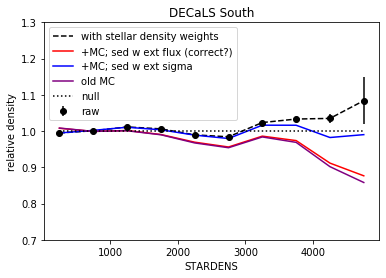

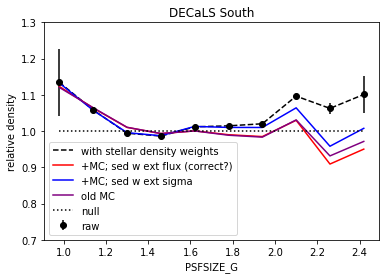

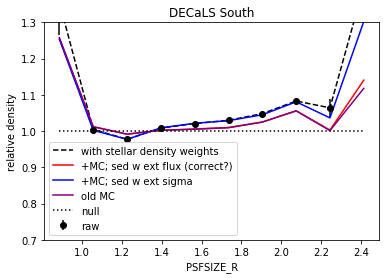

/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


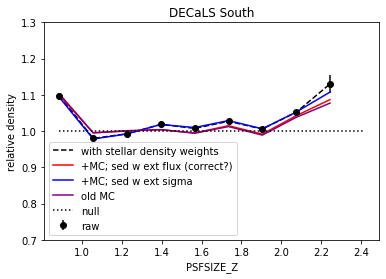

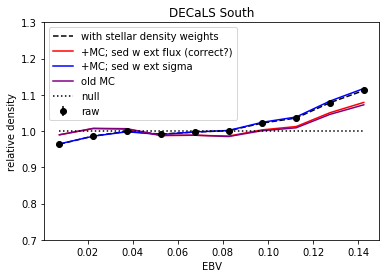

g band depth, extinction corrected


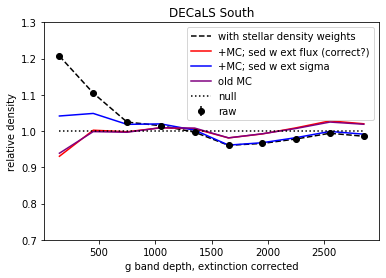

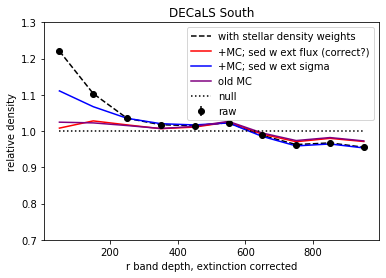

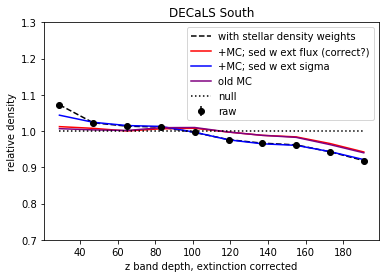

In [42]:
title = 'DECaLS South'
effac=2.
slp = 0
b = 1.
ws = 1./(slp*hpq['STARDENS']+b)

plotvshp_compmc(pixlrds,pixlgds,'STARDENS',(0,0.5e4),title=title,effac=effac)
plotvshp_compmc(pixlrds,pixlgds,'PSFSIZE_G',(.9,2.5),title=title,effac=effac)
plotvshp_compmc(pixlrds,pixlgds,'PSFSIZE_R',(.8,2.5),title=title,effac=effac)
plotvshp_compmc(pixlrds,pixlgds,'PSFSIZE_Z',(.8,2.5),title=title,effac=effac)
plotvshp_compmc(pixlrds,pixlgds,'EBV',(0,0.15),title=title,effac=effac)
plotvshp_compmc(pixlrds,pixlgds,'gdc',(0,3000),title=title,effac=effac)
plotvshp_compmc(pixlrds,pixlgds,'rdc',(0,1000),title=title,effac=effac)
plotvshp_compmc(pixlrds,pixlgds,'zdc',(20,200),title=title,effac=effac)

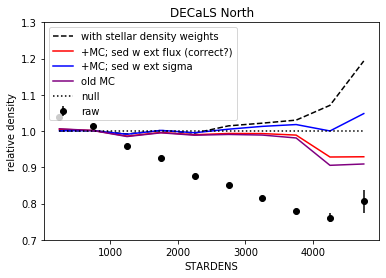

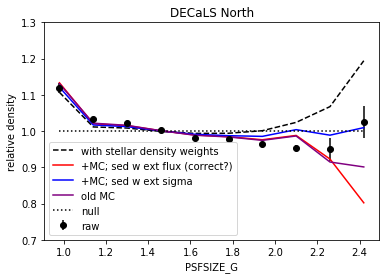

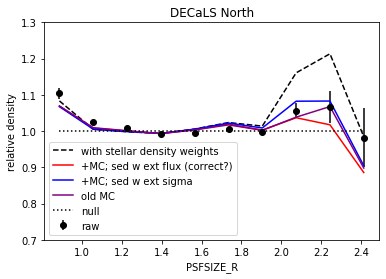

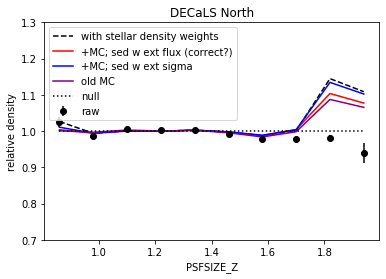

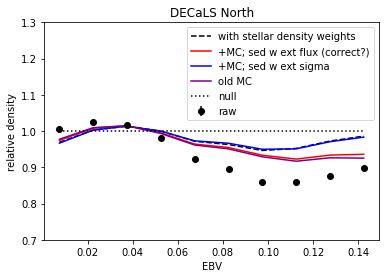

g band depth, extinction corrected


/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


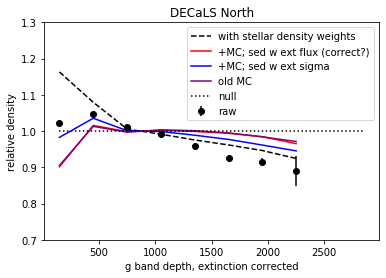

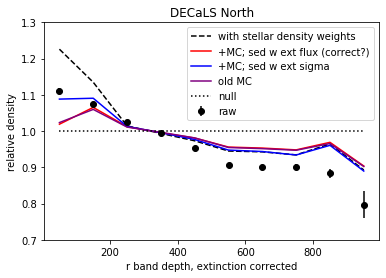

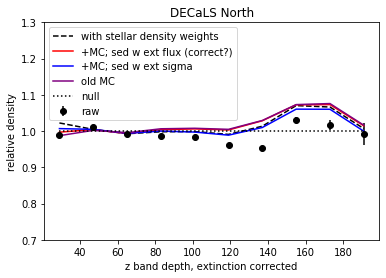

In [43]:
title = 'DECaLS North'
effac=2.
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*hpq['STARDENS']+b)

plotvshp_compmc(pixlrdn,pixlgdn,'STARDENS',(0,0.5e4),title=title,effac=effac)
plotvshp_compmc(pixlrdn,pixlgdn,'PSFSIZE_G',(.9,2.5),title=title,effac=effac)
plotvshp_compmc(pixlrdn,pixlgdn,'PSFSIZE_R',(.8,2.5),title=title,effac=effac)
plotvshp_compmc(pixlrdn,pixlgdn,'PSFSIZE_Z',(.8,2.),title=title,effac=effac)
plotvshp_compmc(pixlrdn,pixlgdn,'EBV',(0,0.15),title=title,effac=effac)
plotvshp_compmc(pixlrdn,pixlgdn,'gdc',(0,3000),title=title,effac=effac)
plotvshp_compmc(pixlrdn,pixlgdn,'rdc',(0,1000),title=title,effac=effac)
plotvshp_compmc(pixlrdn,pixlgdn,'zdc',(20,200),title=title,effac=effac)

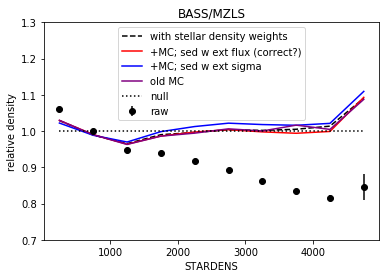

/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


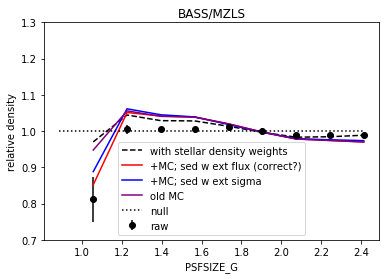

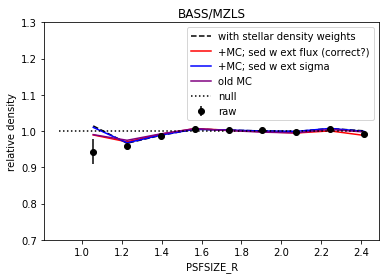

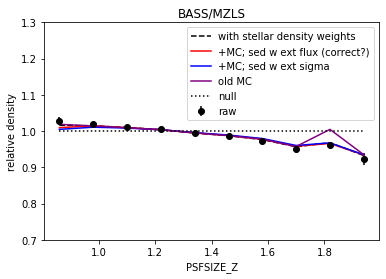

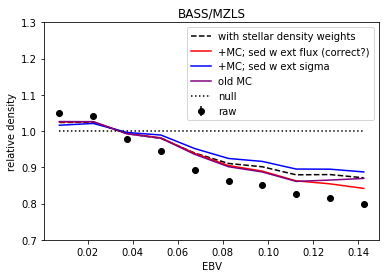

g band depth, extinction corrected


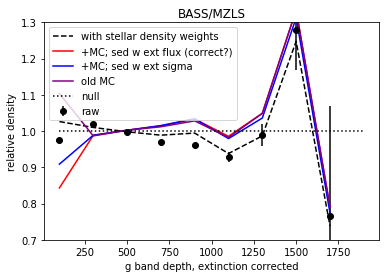

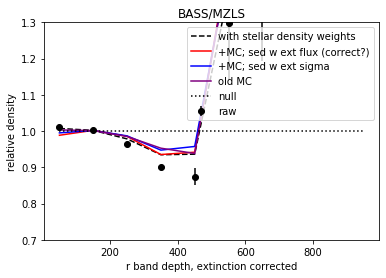

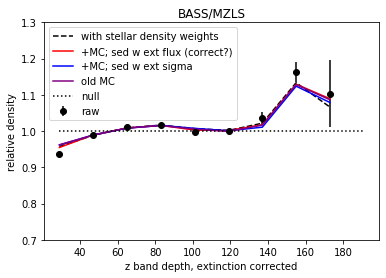

In [44]:
title = 'BASS/MZLS'
effac=1.
slp = -0.25/4000.
b = 1.1
ws = 1./(slp*hpq['STARDENS']+b)
cs = True

plotvshp_compmc(pixlrbm,pixlgbm,'STARDENS',(0,0.5e4),title=title,effac=effac)
plotvshp_compmc(pixlrbm,pixlgbm,'PSFSIZE_G',(.8,2.5),title=title,effac=effac)
plotvshp_compmc(pixlrbm,pixlgbm,'PSFSIZE_R',(.8,2.5),title=title,effac=effac)
plotvshp_compmc(pixlrbm,pixlgbm,'PSFSIZE_Z',(.8,2.),title=title,effac=effac)

plotvshp_compmc(pixlrbm,pixlgbm,'EBV',(0,0.15),title=title,effac=effac)
plotvshp_compmc(pixlrbm,pixlgbm,'gdc',(0,2000),title=title,effac=effac)
plotvshp_compmc(pixlrbm,pixlgbm,'rdc',(0,1000),title=title,effac=effac)
plotvshp_compmc(pixlrbm,pixlgbm,'zdc',(20,200),title=title,effac=effac)